In [1]:
import torch
import cv2
import onnxruntime as ort
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def letterbox(im, new_shape=(320, 320), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

In [2]:
weight_path = "../data/models/YoloV7_Tiny.onnx"
provider = ['CPUExecutionProvider']
gesture = "call"

In [3]:
session = ort.InferenceSession(weight_path, providers=provider)

In [4]:
image_file = os.listdir(f"../data/subsample/{gesture}/")[-1]
image = cv2.imread(f"../data/subsample/{gesture}/{image_file}")
imgList = [image]

In [5]:
origin_RGB = []
resize_data = []
for img in imgList:
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  origin_RGB.append(img)
  image = img.copy()
  image, ratio, dwdh = letterbox(image, auto=False)
  image = image.transpose((2, 0, 1))
  image = np.expand_dims(image, 0)
  image = np.ascontiguousarray(image)
  im = image.astype(np.float32)
  resize_data.append((im,ratio,dwdh))

In [6]:
np_batch = np.concatenate([data[0] for data in resize_data])

In [22]:
image, ratio, dwdh = letterbox(image, auto=False)

In [25]:
np.expand_dims(image, 0).shape

(1, 320, 320, 3)

In [7]:
im = np.ascontiguousarray(np_batch[0:1,...]/255)
outname = [i.name for i in session.get_outputs()]

out = session.run(outname, {'images': im})[0]

0.861


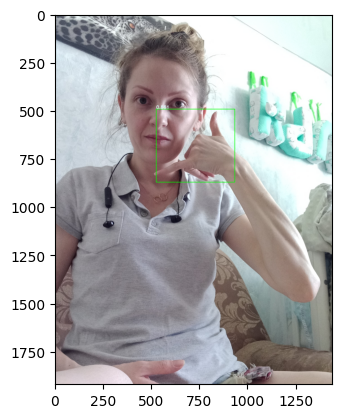

In [8]:


for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(out):
    if score < 0.7:
        continue
    if batch_id >= 6:
        break
    image = origin_RGB[int(batch_id)]
    ratio,dwdh = resize_data[int(batch_id)][1:]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    color = (0,255,0)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    print(score)
    cv2.putText(image,f"{score}",(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)
plt.imshow(origin_RGB[0])